In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

# Question 2
# a) Solving the flow simulation
### Define the pressure solver

In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    imax = len(p)
    jmax = np.size(p)//imax
    while tol > rtol:
        it += 1
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        #this version is valid for dx!=dy
        p[1:-1, 1:-1] = 1.0/(2.0+2.0*(dx**2)/(dy**2))*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                (p_old[1:-1, 2:] + p_old[1:-1,:-2])*(dx**2)/(dy**2)
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the no slip walls    
        p[1:-1, 0] = p[1:-1, 1]
        p[-1,1:-1] = p[-2,1:-1]
        #p[0, :-(jmax-jmax//2) + 1] = p[1, :-(jmax-jmax//2) + 1]
        p[:-(imax-imax//2) + 1, -1] = p[:-(imax-imax//2) + 1, -2] #Top wall

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

### Supplymentry function

In [4]:
def calculate_ppm_RHS_upwind(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use upwind differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] =rho*(np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] < 0],
                      [np.diff(u[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u[1:, 1:-1], n=1, axis=0)/dx]) + 
              np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] < 0],
                      [np.diff(v[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v[1:-1, 1:], n=1, axis=1)/dy]))
    return RHS

def calculate_ppm_RHS_central(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dy) ))
    return RHS

def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )
    
    #apply the velocity boundary condition to the projected velocity data
    imax = len(u)
    jmax = np.size(u)//imax
    u[0,:] = u[1,:]
    v[imax//2:,-1] = v[imax//2:,-2]
    
    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    
    return u, v

### My function for stopping criteria when reach steady states

In [36]:
def has_reached_steady_state(old_field, new_field, tolerance=1e-8):
    """
    Check if the simulation has reached a steady state by comparing the change in field values.
    
    Parameters:
    old_field : numpy.ndarray
        The field values at the previous time step.
    new_field : numpy.ndarray
        The field values at the current time step.
    tolerance : float
        The threshold below which the system is considered to have reached a steady state.
    
    Returns:
    bool
        True if the system is at steady state, False otherwise.
    """
    return np.all(np.abs(new_field - old_field) < tolerance)


### The updated Navier-stokes solver with boundary updation and steady state detection

In [37]:
def solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    
    steady_state_reached = False
    while t < t_end and not steady_state_reached:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
        else:
            dt = dt_min
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp

        steady_state_reached = has_reached_steady_state(u_old, u) and \
                       has_reached_steady_state(v_old, v)
        
        if(steady_state_reached):
            print("Steady state reached at time: ", t)

    return u, v, p

### Define required physical parameters and initialize gird and inital boundary condition

In [68]:
# physical parameters
rho = 1000
nu = 0.001/1000.

# define spatial mesh
# Size of rectangular domain
Lx = 0.01
Ly = 0.005
P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 76

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(u)
jmax = np.size(u)//imax
p[0,] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-4

t_end = 10

### Run the simulation

In [39]:
import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.06380770
pressure solve iterations =    2
norm(u) = 0.26323235, norm(v) = 0.12870711
Courant number: 0.00500420

Time = 0.09894732
pressure solve iterations =    3
norm(u) = 0.39822013, norm(v) = 0.19235762
Courant number: 0.00500206

Time = 0.12733738
pressure solve iterations =    3
norm(u) = 0.50361365, norm(v) = 0.24091704
Courant number: 0.00500131

Time = 0.15215100
pressure solve iterations =    2
norm(u) = 0.59328520, norm(v) = 0.28159729
Courant number: 0.00500099

Time = 0.17464164
pressure solve iterations =    2
norm(u) = 0.67264048, norm(v) = 0.31721730
Courant number: 0.00500076

Time = 0.19546137
pressure solve iterations =    3
norm(u) = 0.74445003, norm(v) = 0.34921086
Courant number: 0.00500064

Time = 0.21499001
pressure solve iterations =    2
norm(u) = 0.81031146, norm(v) = 0.37839441
Courant number: 0.00500056

Time = 0.23346437
pressure solve iterations =    3
norm(u) = 0.87121924, norm(v) = 0.40526710
Courant number: 0.00500048

Time = 0.25105930
press

Text(0.5, 1.0, 'Pressure driven problem - speed')

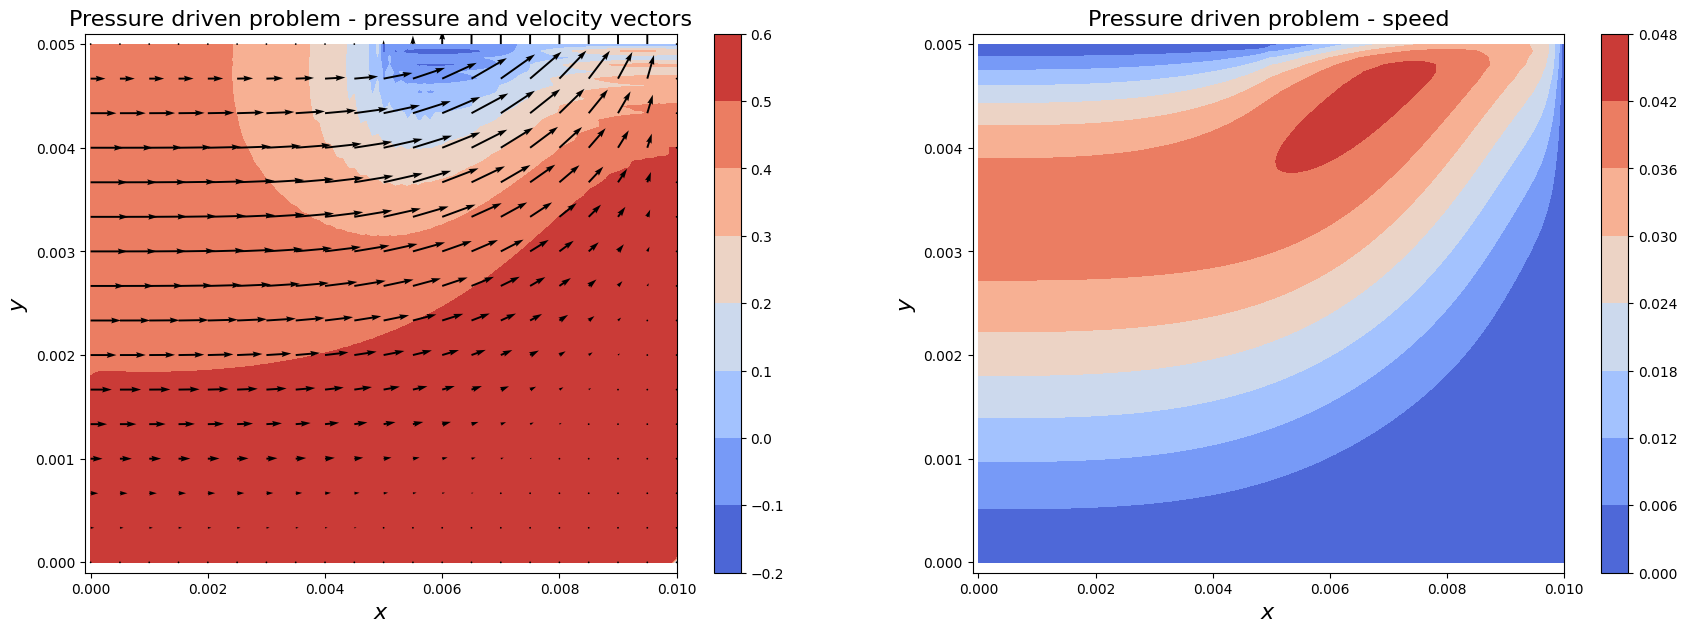

In [40]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0001, 0.01)
ax1.set_ylim(-0.0001, 0.0051)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0001, 0.01)
ax1.set_ylim(-0.0001, 0.0051)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

In [69]:
flow_in = np.average(u[0,:])*Ly
flow_out = np.average(v[:,-1])*Lx

print('flow in: ',flow_in)
print('flow out: ',flow_out)

flow in:  0.0
flow out:  0.0


# b)Finite Difference Approximation for Advection-Diffusion Equation

Given the advection-diffusion equation:

$$\frac{\partial T}{\partial t} = -\vec{v} \cdot \nabla T + k \nabla^2 T $$

where:

- ( T ) is the temperature,
- ( $\vec{v}$ ) is the velocity field,
- ( k ) is the diffusion coefficient.

We will derive a finite difference approximation for time-stepping this equation.

## Temporal Discretization

We use the Forward Euler method for the time derivative:

$$\frac{\partial T}{\partial t} \approx \frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t}$$

where $T^n_{i,j}$ is the temperature at the current time step and grid point(i, j), and $T^{n+1}_{i,j}$ is the temperature at the next time step at the same grid point.

## Spatial Discretization

### Advection Term

Using an upwind scheme for the advection term:

- If \( v<sub>x</sub> > 0 \):

$$-\vec{v} \cdot \nabla T \approx -v_x \frac{T^n_{i,j} - T^n_{i-1,j}}{\Delta x}$$

- If \( v<sub>x</sub> <= 0 \):

$$-\vec{v} \cdot \nabla T \approx -v_x \frac{T^n_{i+1,j} - T^n_{i,j}}{\Delta x}$$

- If \( v<sub>y</sub> > 0 \):

$$-\vec{v} \cdot \nabla T \approx -v_y \frac{T^n_{i,j} - T^n_{i,j-1}}{\Delta y}$$

- If \( v<sub>y</sub> <= 0 \):

$$-\vec{v} \cdot \nabla T \approx -v_y \frac{T^n_{i,j+1} - T^n_{i,j}}{\Delta y}$$

### Diffusion Term

Using a central difference scheme for the Laplacian:

$$k \nabla^2 T \approx k \left[ \frac{T^n_{i+1,j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i,j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2} \right]$$

## Combined Finite Difference Equation

The finite difference equation for the temperature update becomes:

$$T^{n+1}_{i,j} = T^n_{i,j} + \Delta t \left[ -v_x \left( \frac{T^n_{_(upwind),_(upwind)} - T^n_{_(upwind),_(upwind)}}{\Delta x} \right) - v_y \left( \frac{T^n_{_(upwind),_(upwind)} - T^n_{_(upwind),_(upwind)}}{\Delta y} \right) + k \left( \frac{T^n_{i+1,j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i,j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2} \right) \right]$$

This equation can be used to step the temperature field forward in time. Note that this is for positive velocity components; for negative velocities, the indices in the advection term should be adjusted to maintain the upwind scheme.

## Stability Considerations

The stability of the scheme is governed by the Courant-Friedrichs-Lewy (CFL) condition for the advection terms and the stability condition for diffusion, which will dictate the maximum allowable time step ( $\Delta t$ ).


# c) Advection-diffusion implement into NS-solver
First define the temperature updation code we derived above

In [11]:
def update_temperature(T, u, v, k, dt, dx, dy, rho, Cp=4184):
    """
    Update the temperature field based on the advection-diffusion equation.
    
    Parameters:
    T    -- the current temperature field
    u, v -- the velocity components of the fluid
    k    -- the thermal diffusivity
    dt   -- time step
    dx, dy -- grid spacing in the x and y directions
    rho  -- density of the fluid
    Cp   -- specific heat capacity of the fluid

    Returns:
    T_new -- the updated temperature field
    """
    # Create a new temperature field
    T_new = np.copy(T)
    
    # Constants for the Peclet number
    Pe_x = rho * Cp * u * dx / k
    Pe_y = rho * Cp * v * dy / k
        
    # Advection terms
    # Create conditions for the upwind scheme
    conditions_x = [u[1:-1, 1:-1] >= 0, u[1:-1, 1:-1] < 0]
    conditions_y = [v[1:-1, 1:-1] >= 0, v[1:-1, 1:-1] < 0]

    # Calculate the advection terms using np.select and np.roll
    adv_x = np.select(conditions_x, [
        u[1:-1, 1:-1] * (T[1:-1, 1:-1] - np.roll(T, 1, axis=0)[1:-1, 1:-1]) / dx,
        u[1:-1, 1:-1] * (np.roll(T, -1, axis=0)[1:-1, 1:-1] - T[1:-1, 1:-1]) / dx
    ])

    adv_y = np.select(conditions_y, [
        v[1:-1, 1:-1] * (T[1:-1, 1:-1] - np.roll(T, 1, axis=1)[1:-1, 1:-1]) / dy,
        v[1:-1, 1:-1] * (np.roll(T, -1, axis=1)[1:-1, 1:-1] - T[1:-1, 1:-1]) / dy
    ])

    # Diffusion terms
    diff_x = k * (np.roll(T, -1, axis=0)[1:-1, 1:-1] - 2 * T[1:-1, 1:-1] + np.roll(T, 1, axis=0)[1:-1, 1:-1]) / dx**2
    diff_y = k * (np.roll(T, -1, axis=1)[1:-1, 1:-1] - 2 * T[1:-1, 1:-1] + np.roll(T, 1, axis=1)[1:-1, 1:-1]) / dy**2

    # Update the temperature field
    T_new[1:-1, 1:-1] = T[1:-1, 1:-1] - dt * (adv_x + adv_y) + dt * (diff_x + diff_y)

    # Boundary conditions
    T_new[0,:] = 20  # Inlet temperature in degrees Celsius

    T_new[:-(imax-imax//2) + 1, -1] = 100 #Top wall
    T_new[(imax-imax//2):, -1] = T_new[(imax-imax//2):, -2]

    T_new[-1,:] = 100  # right boundary temperature

    T_new[1:-1,0] = 100 # bottom boundary temperature

    
    return T_new


### Modified NS-solver with temp updation
I added the temp updation function into the NS_solver function, as well as adding the third steady-state condition. Also at the $\Delta t$ selection, add a loop break and tell user if the dt is too high and reduce the courant number, as well as the required minimum $\Delta t$.

In [89]:
def solve_NS_with_Temp_update(u, v, p, T, k, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    T_old = T.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    steady_state_reached = False
    while t < t_end and not steady_state_reached:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
        else:
            dt = dt_min

        if(not dt < dx**2/(2*k)/10):
            print("dt is too high, please reduce courant number, minimum dt is: ", dx**2/(2*k)/10)
            break
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        T = update_temperature(T, u, v, k, dt, dx, dy, rho, Cp=1)

        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
        temp = T_old
        T_old = T
        T = temp
        
        # Check if the system has reached a steady state
        steady_state_reached = has_reached_steady_state(u_old, u) and \
                       has_reached_steady_state(v_old, v) and \
                       has_reached_steady_state(T_old, T,tolerance=1e-4)
        if(steady_state_reached):
            print("Steady state reached at time: ", t)

    return u, v, p, T

### Redefine the parameters and boundary conditions, and initialize the simulation

In [105]:
# redefine physical parameters
rho = 1000
nu = 0.001/1000.
k = 5e-6
rho = 1000
nu = 0.001/1000.

# define spatial mesh
# Size of rectangular domain
Lx = 0.01
Ly = 0.005
P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 76

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)
T = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(u)
jmax = np.size(u)//imax
p[0,] = P_max
p[imax//2:, -1] = 0.0


# Boundary conditions
T[0,:] = 20  # Inlet temperature in degrees Celsius
T[len(T)//2:,-1] = 0.0  #Top boundary
T[:len(T)//2,-1] = 100
T[-1,:] = 100  # Right boundary temperature 
T[1:-1,0] = 100 # bottom boundary temperature

courant = 0.005
dt_min = 1.e-5

t_end = 10
import time
start = time.time()
u, v, p ,T= solve_NS_with_Temp_update(u, v, p, T, k, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.01000000
pressure solve iterations =    1
norm(u) = 0.04355163, norm(v) = 0.02146672
Courant number: 0.00031737

Time = 0.02000000
pressure solve iterations =    1
norm(u) = 0.08579010, norm(v) = 0.04224900
Courant number: 0.00053943

Time = 0.03000000
pressure solve iterations =    1
norm(u) = 0.12715492, norm(v) = 0.06251785
Courant number: 0.00071041

Time = 0.04000000
pressure solve iterations =    1
norm(u) = 0.16781028, norm(v) = 0.08232243
Courant number: 0.00086329

Time = 0.05000000
pressure solve iterations =    1
norm(u) = 0.20785160, norm(v) = 0.10169569
Courant number: 0.00100639

Time = 0.06000000
pressure solve iterations =    1
norm(u) = 0.24734392, norm(v) = 0.12066404
Courant number: 0.00113938

Time = 0.07000000
pressure solve iterations =    1
norm(u) = 0.28633506, norm(v) = 0.13925104
Courant number: 0.00125966

Time = 0.08000000
pressure solve iterations =    1
norm(u) = 0.32486160, norm(v) = 0.15747863
Courant number: 0.00137395

Time = 0.09000000
press

Text(0.5, 1.0, 'Pressure driven problem - pressure and velocity vectors')

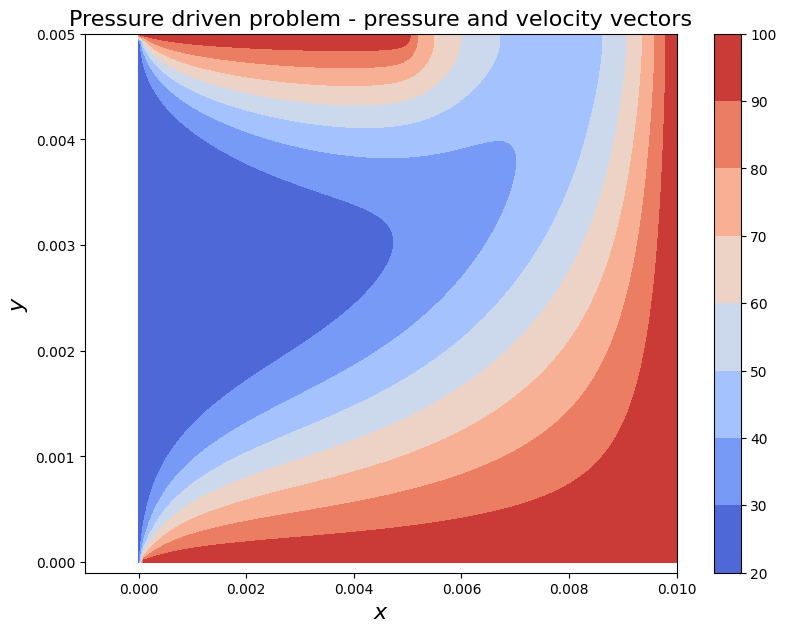

In [106]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.set_xlim(-0.001, 0.01)
ax1.set_ylim(-0.0001, 0.005)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

### Add a function to calculate the avergage outflow temperature

In [108]:
def calculate_average_outflow_temperature(T, u, v, dx, dy):
    """
    Calculate the flow average outflow temperature.
    
    Parameters:
    T : 2D array of temperature values.
    u : 2D array of horizontal velocity values.
    v : 2D array of vertical velocity values.
    dx: Spatial step in the x-direction.
    dy: Spatial step in the y-direction.

    Returns:
    float : The average outflow temperature.
    """
    # Assume the outflow is on the right half of the top boundary.
    # We will take the top row for v velocities and the corresponding temperatures.
    half_Nx = len(T) // 2
    
    # Get the right half of the top boundary temperatures and velocities.
    outflow_velocities = v[0, half_Nx:]

    outflow_temps = T[len(T)//2:,-1]
    outflow_velocities = v[len(T)//2:,-1]
    
    # Calculate the weighted average of the temperature.
    # The weighting factor is the outflow velocity.
    weighted_temps = outflow_temps * outflow_velocities
    
    # Calculate the average outflow velocity.
    avg_outflow_velocity = np.mean(outflow_velocities)
    
    # If the average outflow velocity is zero or very small, return the simple average temperature
    # to avoid division by zero.
    if np.abs(avg_outflow_velocity) < 1e-8:
        return np.mean(outflow_temps)
    
    # Calculate the flow average outflow temperature.
    flow_avg_outflow_temp = np.sum(weighted_temps) / np.sum(outflow_velocities)
    
    return flow_avg_outflow_temp

# Example usage:
# Assuming T, u, and v are defined as per the provided Navier-Stokes simulation results.
# Calculate the average outflow temperature.
average_outflow_temp = calculate_average_outflow_temperature(T, u, v, dx, dy)
print("The flow average outflow temperature is: {:.2f} C".format(average_outflow_temp))


The flow average outflow temperature is: 55.52 C


# D) Parameter investigation
To investigate the effect of the physical parameters on our final result (average outflow temperature), we have to first understand our field of simulation. We are fundamentally solve an advection-diffusion equation, which the advection term is calculated by solving a pressure driven navier-stokes equation.

To step back from the math and physics equation, the system is a heater that feeds in cool water from the inlet to the outlet, and the wall acts as the heating compartment. The average outflow temperature thus is dominated by how fast the flow of water and how fast is the heat diffused into the water. If the water runs too fast, we do not have enough time to allow heating through heat diffusion, whereas if the water runs too slow or the heat diffuses really fast, the outflow will become very hot, as the inlet cool water will be heated completely.

Thus the answer is basically dominated by the Peclet number which in the equation is:
$$Pe = \frac{U*L}{K}$$
where U is the velocity magnitude, L is the characteristic length and K is the diffusion coefficient. If Pe is much greater than 1, the system is Advection dominated, if Pe is way less than 1, the system is diffusion dominated. As we are solving a pressure driven navier-stokes equation, the velocity is govern by the pressure drop, therefore I would investigate the effect of pressure drop vs the diffusitivity over the final average outflow temperature.

First I will define a function that plots the perclet number field to help visualize the field.

In [112]:
def plot_peclet_number_field(u, v, Lx, Ly, D):
    """
    Calculate and plot the Péclet number field.

    Parameters:
    u : 2D array
        Horizontal velocity field.
    v : 2D array
        Vertical velocity field.
    dx : float
        Spatial step in the x-direction.
    dy : float
        Spatial step in the y-direction.
    D : float
        Diffusion coefficient.
    Lx : float
        Length of the domain in the x-direction.
    Ly : float
        Length of the domain in the y-direction.
    """
    # Calculate velocity magnitude
    U = np.sqrt(u**2 + v**2)
    
    # Characteristic length (use smaller of domain dimensions)
    L = min(Lx, Ly)

    # Calculate Péclet number field
    Pe_field = U * L / D

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.contourf(X,Y,Pe_field, cmap=cm.viridis)
    plt.colorbar(label='Péclet Number')
    plt.title('Péclet Number Field')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

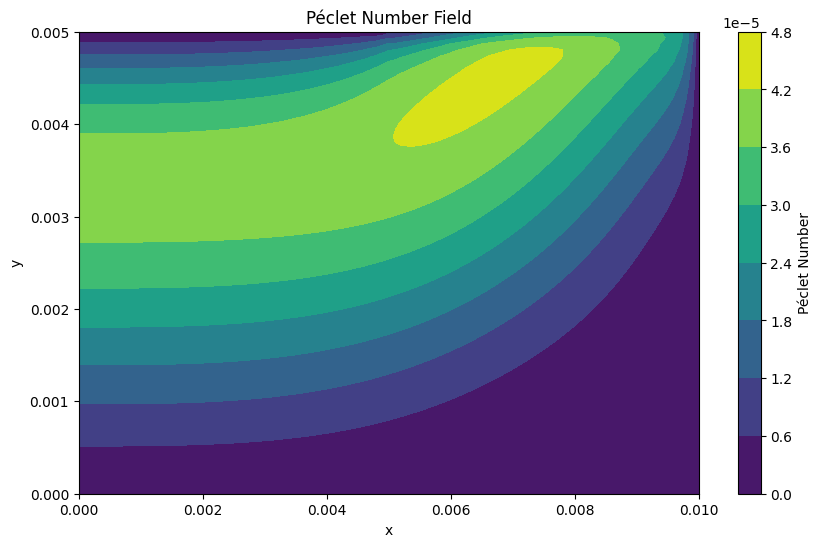

In [113]:
# Example usage
# Assuming you have the velocity fields 'u' and 'v', and the domain dimensions 'Lx', 'Ly',
# and a given diffusion coefficient 'D'.
plot_peclet_number_field(u, v, k, Lx, Ly)

Create simulation that has double the pressure drop.

In [142]:
# redefine physical parameters
rho = 1000
nu = 0.001/1000.
k = 5e-6
nu = 0.001/1000.

# define spatial mesh
# Size of rectangular domain
Lx = 0.01
Ly = 0.005
P_max = 1

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = 26

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)
T = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(u)
jmax = np.size(u)//imax
p[0,] = P_max
p[imax//2:, -1] = 0.0


# Boundary conditions
T[0,:] = 20  # Inlet temperature in degrees Celsius
T[len(T)//2:,-1] = 0.0  #Top boundary
T[:len(T)//2,-1] = 100
T[-1,:] = 100  # Right boundary temperature 
T[1:-1,0] = 100 # bottom boundary temperature

courant = 0.005
dt_min = 1.e-5

t_end = 3
import time
start = time.time()
u, v, p ,T= solve_NS_with_Temp_update(u, v, p, T, k, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.01000000
pressure solve iterations =    2
norm(u) = 0.03478825, norm(v) = 0.01760152
Courant number: 0.00018845

Time = 0.02000000
pressure solve iterations =    2
norm(u) = 0.06857397, norm(v) = 0.03440916
Courant number: 0.00031995

Time = 0.03000000
pressure solve iterations =    3
norm(u) = 0.10148697, norm(v) = 0.05057645
Courant number: 0.00042358

Time = 0.04000000
pressure solve iterations =    2
norm(u) = 0.13361863, norm(v) = 0.06617387
Courant number: 0.00051657

Time = 0.05000000
pressure solve iterations =    2
norm(u) = 0.16503892, norm(v) = 0.08125501
Courant number: 0.00059211

Time = 0.06000000
pressure solve iterations =    2
norm(u) = 0.19579899, norm(v) = 0.09586577
Courant number: 0.00065964

Time = 0.07000000
pressure solve iterations =    2
norm(u) = 0.22593560, norm(v) = 0.11004625
Courant number: 0.00072904

Time = 0.08000000
pressure solve iterations =    1
norm(u) = 0.25547431, norm(v) = 0.12383099
Courant number: 0.00079268

Time = 0.09000000
press

Text(0.5, 1.0, 'Pressure driven problem - speed')

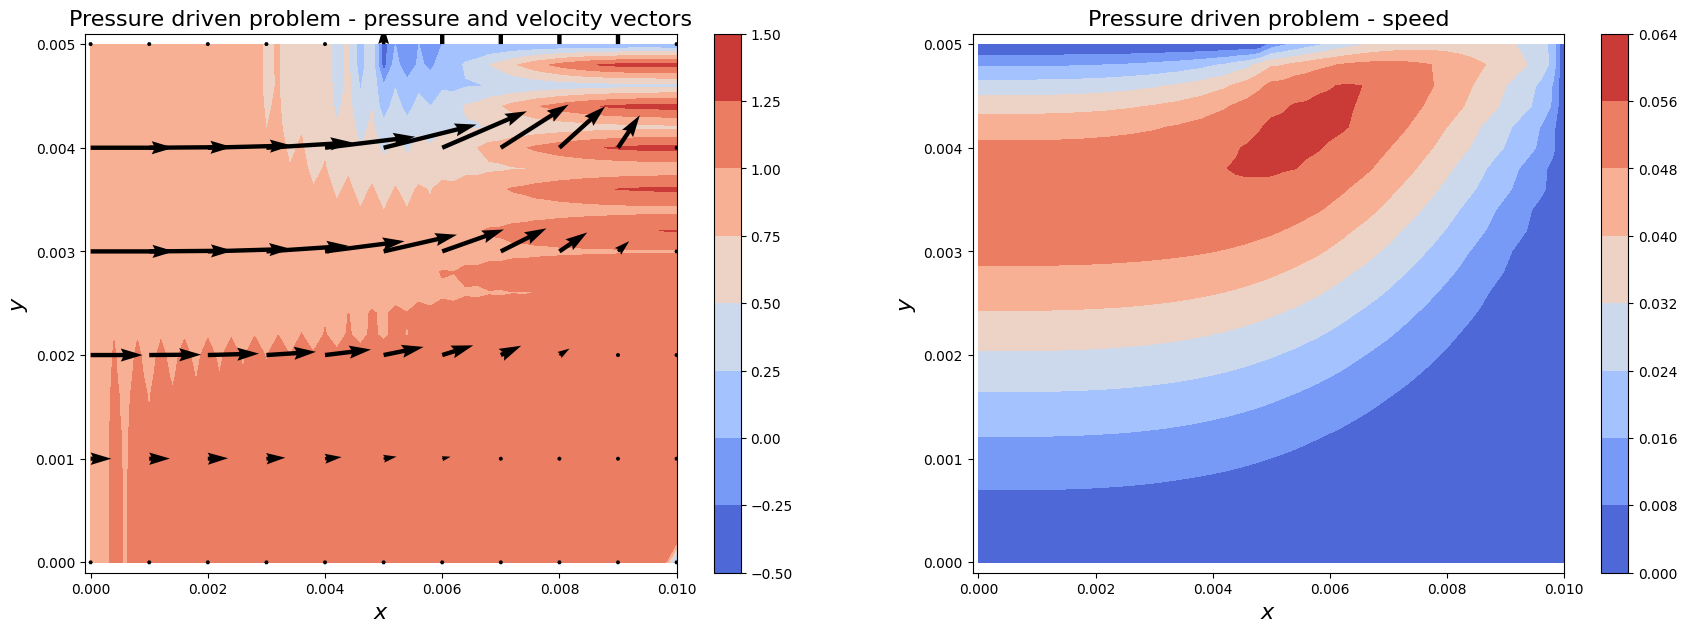

In [143]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0001, 0.01)
ax1.set_ylim(-0.0001, 0.0051)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0001, 0.01)
ax1.set_ylim(-0.0001, 0.0051)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

Text(0.5, 1.0, 'Pressure driven problem - pressure and velocity vectors')

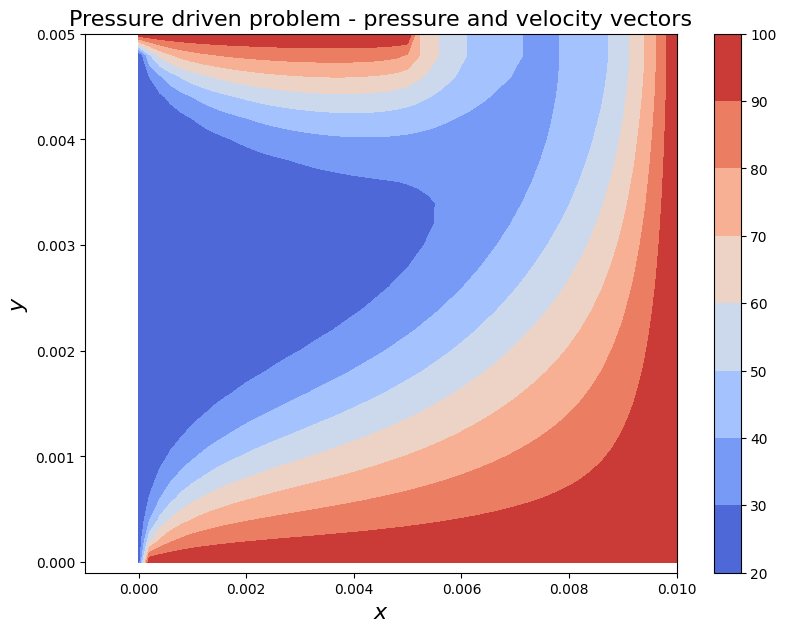

In [144]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.set_xlim(-0.001, 0.01)
ax1.set_ylim(-0.0001, 0.005)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

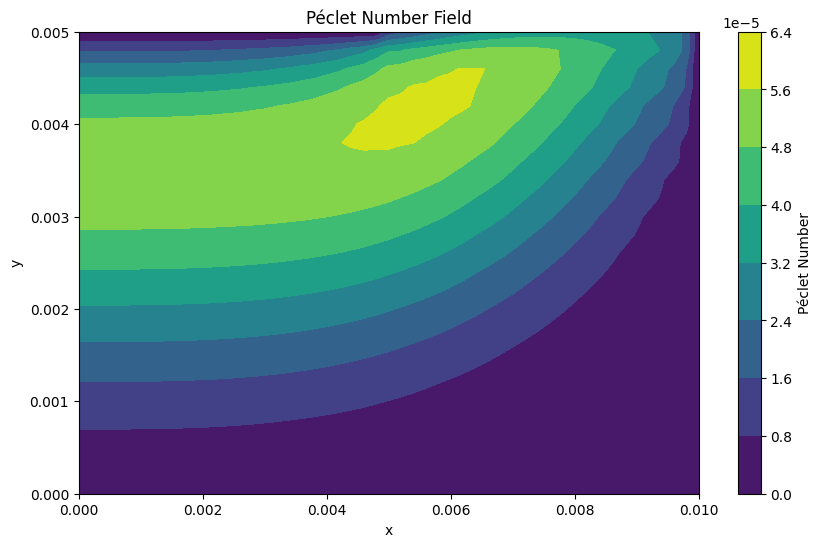

In [145]:
plot_peclet_number_field(u, v, k, Lx, Ly)

In [ ]:
# Size of rectangular domain
Lx = 0.01
Ly = 0.005
P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 26
Ny = 13

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y

# Define a range of diffusivities and pressure drops to test
diffusivities = [5e-4, 5e-5, 5e-6, 5e-7, 5e-8]  # Example values for k
pressure_drops = [0.1, 0.25, 0.5, 1.0, 2]  # Example values for P_max

# Prepare arrays to store results
results = np.zeros((len(diffusivities), len(pressure_drops)))

# Run simulations for each combination of k and P_max
for i in range(len(diffusivities)):
        # Initialize fields
        u = np.zeros_like(X)
        v = np.zeros_like(X)
        p = np.zeros_like(X)
        T = np.zeros_like(X)

        k = diffusivities[i]
        P_max = pressure_drops[i]

        # Apply Dirichlet BCs to u and v - the code below doesn't touch 
        # these so we can do this once outside the time loop
        u[:, -1] = 0
        u[:, 0] = 0
        u[0, :] = 0
        u[-1, :] = 0
        v[:, -1] = 0
        v[:, 0] = 0
        v[0, :] = 0
        v[-1, :] = 0
        imax = len(u)
        jmax = np.size(u)//imax
        p[0,] = P_max
        p[imax//2:, -1] = 0.0


        # Boundary conditions
        T[0,:] = 20  # Inlet temperature in degrees Celsius
        T[len(T)//2:,-1] = 0.0  #Top boundary
        T[:len(T)//2,-1] = 100
        T[-1,:] = 100  # Right boundary temperature 
        T[1:-1,0] = 100 # bottom boundary temperature

        courant = 0.0005
        dt_min = 1.e-6

        t_end = 3
        # Run the solver
        u, v, p, T = solve_NS_with_Temp_update(u, v, p, T, k, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs=False, outint=1000)

        # Calculate average outflow temperature
        avg_temp = calculate_average_outflow_temperature(T, u, v, dx, dy)
        results[i] = avg_temp
        print(f"k={k}, P_max={P_max}, Avg Outflow Temp: {avg_temp:.2f} C")


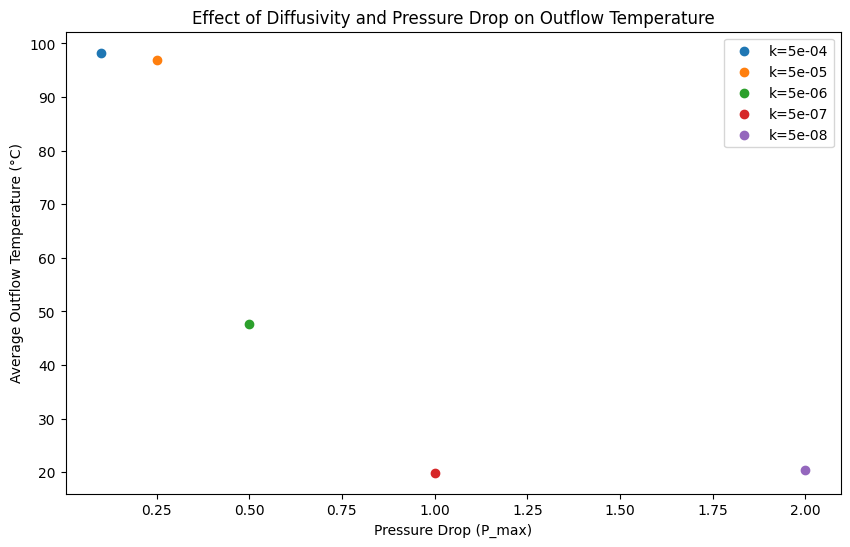

In [141]:
import matplotlib.pyplot as plt

# Provided data
k_values = [0.0005, 5e-05, 5e-06, 5e-07, 5e-08]  # Diffusivity
P_max_values = [0.1, 0.25, 0.5, 1.0, 2.0]  # Pressure drop
avg_temp_values = [98.27, 96.93, 47.68, 19.92, 20.45]  # Average outflow temperature

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting the data
for i in range(len(k_values)):
    plt.scatter(P_max_values[i], avg_temp_values[i], label=f'k={k_values[i]:.0e}')

# Adding labels and title
plt.xlabel('Pressure Drop (P_max)')
plt.ylabel('Average Outflow Temperature (°C)')
plt.title('Effect of Diffusivity and Pressure Drop on Outflow Temperature')
plt.legend()

# Showing the plot
plt.show()


The solution demonstrates a clear relationship between the diffusion coefficient (k), pressure drop (P_max), and the average outflow temperature in a fluid flow scenario governed by the Navier-Stokes equations and an advection-diffusion thermal model. As observed from the data, there are distinct trends:

With an increasing diffusion coefficient (k): The average outflow temperature tends to be higher. This is indicative of a stronger diffusion effect, which in the context of temperature means more effective heat spreading throughout the fluid. A higher k enhances the distribution of thermal energy, thereby raising the overall temperature of the outflowing fluid.

With an increasing pressure drop (P_max): The average outflow temperature shows a decreasing trend. This suggests that higher pressure drop leads to more dynamic flow, enhancing advection (the transport of heat by the motion of the fluid). In such cases, advection can outpace diffusion in influencing the temperature distribution, particularly at higher pressure drops.

The trends align with the conceptual understanding provided by the Péclet number, a dimensionless group indicating the relative effects of advection and diffusion. A low Péclet number (dominated by higher k, lower velocities) suggests that diffusion is the primary mechanism of thermal energy transport, leading to a more uniform and potentially higher temperature distribution. Conversely, a high Péclet number (dominated by lower k, higher velocities, or higher pressure drops leading to more vigorous flow) implies that advection is more influential, possibly resulting in lower outflow temperatures as less time is allowed for heat to diffuse throughout the fluid before being carried away.

Therefore, the observed trends and their alignment with the implications of the Péclet number underscore the interplay between physical parameters in dictating the thermal characteristics of fluid flow.